In [1]:
import pandas as pd

s3_uri = "s3://amazon-sagemaker-730335348097-us-east-1-028ed1706034/data/calories.csv"
df = pd.read_csv(s3_uri)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [6]:
# 1. Init Git
!git init

Reinitialized existing Git repository in /home/sagemaker-user/src/mlops-calories/notebooks/.git/


In [7]:
# 2. Install DVC with S3 support (ignore the fsspec warning for now)
!pip install 'dvc[s3]' --quiet

In [9]:
# 3. Init DVC inside Git repo
!dvc init -f

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [12]:
# 4. Set up S3 as DVC remote
!dvc remote add -f -d myremote s3://amazon-sagemaker-730353348097-us-east-1-028ed1706034/dvcstore
!dvc remote modify myremote endpointurl https://s3.amazonaws.com

Setting 'myremote' as a default remote.


### Create Dataset

In [13]:
# Create 80% subset
df_80 = df.iloc[:int(0.8 * len(df))]

# Save locally
df_80.to_csv("calories_v1.csv", index=False)
df.to_csv("calories_full.csv", index=False)

### Track with DVC

In [14]:
# This generates .dvc files (calories_v1.csv.dvc and calories_full.csv.dvc)
!dvc add calories_v1.csv
!dvc add calories_full.csv

⠋ Checking graph
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
                                                                                
!
  0%|          |Adding calories_v1.csv to cache       0/1 [00:00<?,     ?file/s]
                                                                                
!
  0%|          |Checking out /home/sagemaker-user/src/0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 12.54file/s]

To track the changes with git, run:

	git add calories_v1.csv.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true
⠋ Checking graph
Adding...                                                                       
!
                                                                                
!
  0

### Push to Remote Storage

✅ Created a new, valid S3 bucket (dvc-store-bucket)

✅ Configured .dvc/config with the correct remote URL

✅ Ran dvc push successfully — your data is now versioned in the cloud!

In [41]:
!dvc remote remove myremote --global || echo "already removed"
!dvc remote remove myremote --local || echo "already removed"

In [42]:
!dvc remote add -f -d myremote s3://dvc-store-bucket --global
!dvc remote modify myremote endpointurl https://s3.amazonaws.com --global

Setting 'myremote' as a default remote.


In [43]:
!cat ~/.config/dvc/config

[core]
    remote = myremote
['remote "myremote"']
    url = s3://dvc-store-bucket
    endpointurl = https://s3.amazonaws.com


In [44]:
!dvc push -v

2025-08-05 22:05:12,726 DEBUG: v3.61.0 (pip), CPython 3.11.11 on Linux-5.10.238-231.953.amzn2.x86_64-x86_64-with-glibc2.35
2025-08-05 22:05:12,727 DEBUG: command: /opt/conda/bin/dvc push -v
2025-08-05 22:05:13,092 DEBUG: Preparing to transfer data from '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/cache/files/md5' to 's3://dvc-store-bucket/files/md5'
2025-08-05 22:05:13,092 DEBUG: Preparing to collect status from 'dvc-store-bucket/files/md5'
2025-08-05 22:05:13,092 DEBUG: Collecting status from 'dvc-store-bucket/files/md5'
Pushing
!
       ecking cache in 'dvc-store-bucket/files/md5'| |0/? [00:00<?,    ?files/s]
2025-08-05 22:05:13,515 DEBUG: Estimated remote size: 4096 files
Pushing
       ecking cache in 'dvc-store-bucket/files/md5'| |0/? [00:00<?,    ?files/s]
2025-08-05 22:05:13,516 DEBUG: Large remote (2 oids < 4.096 traverse weight), using object_exists for remaining oids
Pushing
       ecking cache in 'dvc-store-bucket/files/md5'| |0/? [00:00<?,    ?files/s]
2025-08-05

In [45]:
# DVC cache was successfully pushed to your new S3 bucket (dvc-store-bucket). The presence of hashed files like: 3f43e706cf11f89c8b966cea1d0317 under the files/md5/11/ path is exactly what DVC uses to store and version data blobs.

### Download versioned data from remote

In [47]:
!dvc pull
!dvc status

Fetching
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
Fetching                                                                        
Building workspace index                              |2.00 [00:00,  168entry/s]
Comparing indexes                                     |3.00 [00:00,  621entry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.
Data and pipelines are up to date.                                              


### Commit .dvc and .gitignore files

In [48]:
!git add *.dvc .gitignore
!git commit -m "Track data with DVC and configure remote storage"
!git push

[master (root-commit) 574f2bd] Track data with DVC and configure remote storage
 6 files changed, 18 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 .gitignore
 create mode 100644 calories_full.csv.dvc
 create mode 100644 calories_v1.csv.dvc
fatal: No configured push destination.
Either specify the URL from the command-line or configure a remote repository using

    git remote add <name> <url>

and then push using the remote name

    git push <name>



In [1]:
# Reset the remote to SSH
!git remote set-url origin git@github.com:luwenkai1997/mlops-calories.git

### Compare two versions of data tracked with DVC and evaluate model performance

In [1]:
# Commit .dvc files and .gitignore to Git

!git add calories_v1.csv.dvc calories_full.csv.dvc .gitignore
!git commit -m "Track calories_v1 and calories_full with DVC"

[master e878f96] Track calories_v1 and calories_full with DVC
 1 file changed, 1 insertion(+)


In [2]:
# Tag version 1 (v1) using calories_v1.csv

!cp calories_v1.csv data.csv
!dvc add data.csv
!git add data.csv.dvc
!git commit -m "Use calories_v1.csv as data.csv for v1"
!git tag v1


⠋ Checking graph
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
                                                                                
!
  0%|          |Checking out /home/sagemaker-user/src/0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 12.09file/s]

To track the changes with git, run:

	git add data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master 10aaaea] Use calories_v1.csv as data.csv for v1
 1 file changed, 2 insertions(+), 2 deletions(-)
fatal: tag 'v1' already exists


In [3]:
# Tag version 2 (v2) using calories_full.csv

!cp calories_full.csv data.csv
!dvc add data.csv
!git add data.csv.dvc
!git commit -m "Use calories_full.csv as data.csv for v2"
!git tag v2


⠋ Checking graph
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
                                                                                
!
  0%|          |Checking out /home/sagemaker-user/src/0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 29.57file/s]

To track the changes with git, run:

	git add data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master 0c645a6] Use calories_full.csv as data.csv for v2
 1 file changed, 2 insertions(+), 2 deletions(-)
fatal: tag 'v2' already exists


In [8]:
# Compare Model Performance Between v1 and v2

def train_and_evaluate(data_path):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    df = pd.read_csv(data_path)

    if "Calories" not in df.columns:
        raise ValueError("Expected 'Calories' column in the dataset.")

    X = df.drop(columns=["Calories"])
    y = df["Calories"]

    # One-hot encode categorical columns (e.g., "Gender")
    X = pd.get_dummies(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R²:  {r2_score(y_test, y_pred):.2f}")

    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

In [9]:
# Run models for v1 and v2

In [10]:
!git checkout v1
!dvc pull

M	.dvc/config
HEAD is now at d0c9ec7 Use calories_v1.csv as data.csv for v1
Fetching
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  539entry/s]
Comparing indexes                                    |4.00 [00:00, 3.12kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.


In [11]:
metrics_v1 = train_and_evaluate("data.csv")

MAE: 8.49
MSE: 134.86
R²:  0.97


In [12]:
!git checkout v2
!dvc pull

M	.dvc/config
Previous HEAD position was d0c9ec7 Use calories_v1.csv as data.csv for v1
HEAD is now at 8bffbc3 Use calories_full.csv as data.csv for v2
Fetching
!
  0% Checking cache in '/home/sagemaker-user/src/mlops-calories/notebooks/.dvc/c
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  549entry/s]
Comparing indexes                                    |4.00 [00:00, 2.67kentry/s]
Applying changes                                      |1.00 [00:00,   374file/s]
M       data.csv
1 file modified


In [13]:
metrics_v2 = train_and_evaluate("data.csv")

MAE: 8.44
MSE: 132.07
R²:  0.97


In [14]:
print("===== Comparison =====")
print(f"MAE: v1 → {metrics_v1['MAE']:.2f}, v2 → {metrics_v2['MAE']:.2f}")
print(f"MSE: v1 → {metrics_v1['MSE']:.2f}, v2 → {metrics_v2['MSE']:.2f}")
print(f"R²:  v1 → {metrics_v1['R2']:.2f}, v2 → {metrics_v2['R2']:.2f}")

===== Comparison =====
MAE: v1 → 8.49, v2 → 8.44
MSE: v1 → 134.86, v2 → 132.07
R²:  v1 → 0.97, v2 → 0.97


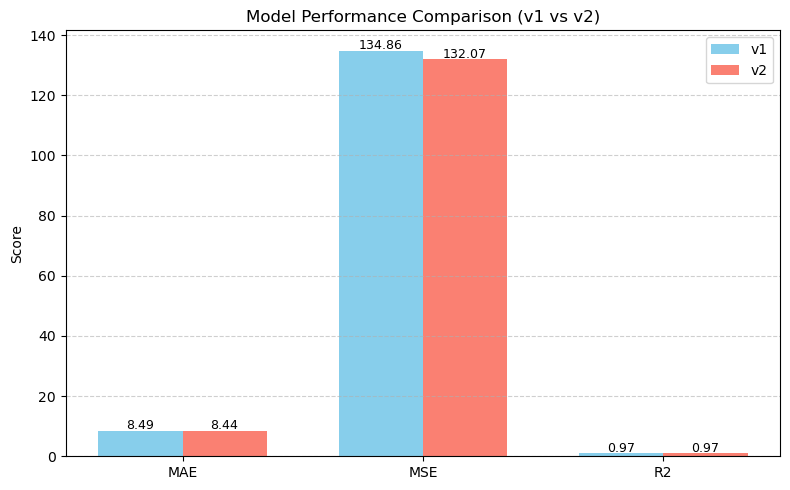

In [15]:
import matplotlib.pyplot as plt

# Extract metrics
metrics = ["MAE", "MSE", "R2"]
v1_scores = [metrics_v1["MAE"], metrics_v1["MSE"], metrics_v1["R2"]]
v2_scores = [metrics_v2["MAE"], metrics_v2["MSE"], metrics_v2["R2"]]

x = range(len(metrics))

plt.figure(figsize=(8, 5))
bar_width = 0.35

# Bar plots for v1 and v2
plt.bar([i - bar_width/2 for i in x], v1_scores, width=bar_width, label="v1", color="skyblue")
plt.bar([i + bar_width/2 for i in x], v2_scores, width=bar_width, label="v2", color="salmon")

# Chart labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison (v1 vs v2)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Annotate values
for i in range(len(metrics)):
    plt.text(i - bar_width/2, v1_scores[i] + 0.5, f"{v1_scores[i]:.2f}", ha='center', fontsize=9)
    plt.text(i + bar_width/2, v2_scores[i] + 0.5, f"{v2_scores[i]:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


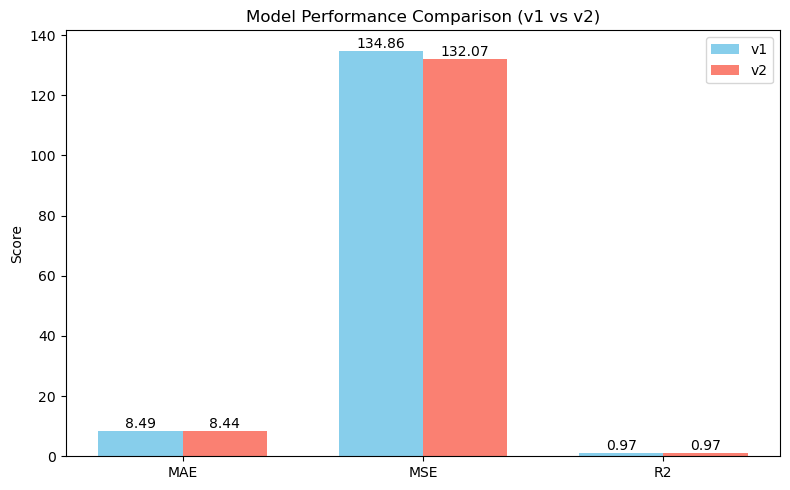

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ["MAE", "MSE", "R2"]
v1_scores = [metrics_v1["MAE"], metrics_v1["MSE"], metrics_v1["R2"]]
v2_scores = [metrics_v2["MAE"], metrics_v2["MSE"], metrics_v2["R2"]]

x = np.arange(len(metrics))
bar_width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - bar_width/2, v1_scores, width=bar_width, label='v1', color='skyblue')
bars2 = ax.bar(x + bar_width/2, v2_scores, width=bar_width, label='v2', color='salmon')

# Labels
ax.set_title("Model Performance Comparison (v1 vs v2)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.legend()

# Add bar value labels
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, v1_scores[i] + 1, f"{v1_scores[i]:.2f}", ha='center')
    ax.text(x[i] + bar_width/2, v2_scores[i] + 1, f"{v2_scores[i]:.2f}", ha='center')

# Save figure BEFORE show
fig.tight_layout()
fig.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')  # Save to current directory
plt.show()
